In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Transformers

/content/drive/My Drive/Colab Notebooks/Transformers


In [5]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchtext import data, datasets, vocab
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import random, tqdm, sys, math, gzip, os
from utils.util import d, save_checkpoint, load_checkpoint
from transformers import CTransformer

In [6]:
def trainF(model, train_loader, val_loader, num_epochs, criterion, save_name):

    gradient_clipping = 1.0
    best_val_loss = float("Inf")
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print('Starting epoch ' + str(epoch + 1))

        for batch in tqdm.tqdm(train_loader):

            input = batch.text[0].to(device)
            label = batch.label - 1
            label = label.to(device)

            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input)
            loss = criterion(out, label)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            #clip gradients
            if gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            tot, cor = 0.0, 0.0

            for batch in val_loader:
                input = batch.text[0].to(device)
                label = batch.label - 1
                label = label.to(device)

                if input.size(1) > mx:
                    input = input[:, :mx]
                out = model(input)
                loss = criterion(out, label)
                val_running_loss += loss.item()

                tot += float(input.size(0))
                cor += float((label == out.argmax(dim=1)).sum().item())

            acc = cor/tot 
            print("validation accuracy {:.3f}".format(acc))
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)

    print("Finished Training")
    return train_losses, val_losses

In [7]:
# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for batch in test_loader:
          input = batch.text[0].to(device)
          label = batch.label - 1
          label = label.to(device)
          if input.size(1) > mx:
            input = input[:, :mx]
          out = model(input)
          if label == out.argmax(dim=1):
            correct += 1
          count += 1 
        print("Current Count is: {}".format(count))
        print('Accuracy on test set: {}'.format(correct/count))

In [8]:
  vocab_size = 50000
  batch_size = 4
  LOG2E = math.log2(math.e)
  TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
  LABEL = data.Field(sequential=False)

In [9]:
tdata, test = datasets.IMDB.splits(TEXT, LABEL, root='/content/drive/My Drive/Colab Notebooks/Transformers/.data/')
train, val = tdata.split(split_ratio=0.8)

TEXT.build_vocab(train, max_size=vocab_size - 2)
LABEL.build_vocab(train)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 22.9MB/s]


In [10]:
train_iter = data.BucketIterator(train, batch_size=batch_size, device=d())
val_iter = data.BucketIterator(val, batch_size=1, device=d())
test_iter = data.BucketIterator(test, batch_size=1, device=d())

# train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=10)
# val_loader = torch.utils.data.DataLoader(val, batch_size=1, num_workers=0, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test, batch_size=1, num_workers=0, shuffle=True)

In [11]:
print(f'- nr. of training examples {len(train_iter)}')
print(f'- nr. of validation examples {len(val_iter)}')
print(f'- nr. of test examples {len(test_iter)}')

- nr. of training examples 5000
- nr. of validation examples 5000
- nr. of test examples 25000


In [82]:
NUM_CLS = 2
embedding_size = 128
num_heads = 8
depth = 6
max_length = 512
max_pool = True

if max_length < 0:
    mx = max([input.text[0].size(1) for input in train_iter])
    mx = mx * 2
    print(f'- maximum sequence length: {mx}')
else:
    mx = max_length
    print(f'- maximum sequence length: {mx}')


#creating the original network and couting the parameters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=mx, num_tokens=vocab_size, num_classes=NUM_CLS, max_pool=max_pool)
if torch.cuda.is_available():
  model.cuda()
temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model architecture:\n\n', model)
print(f'\nThe model has {temp:,} trainable parameters')

- maximum sequence length: 512
The model architecture:

 CTransformer(
  (token_embedding): Embedding(50000, 128)
  (pos_embedding): Embedding(512, 128)
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttentionNarrow(
        (tokeys): Linear(in_features=16, out_features=16, bias=False)
        (toqueries): Linear(in_features=16, out_features=16, bias=False)
        (tovalues): Linear(in_features=16, out_features=16, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (do): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): SelfAttentionNarrow(
        (tokeys): Li

In [13]:
# start training
optimizer = torch.optim.Adam(lr = 0.0001, params=model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda i: min(i / (10000/batch_size), 1.0))
num_epochs = 10
criterion = nn.NLLLoss()
save_path = 'CTransformersNet.pt'
# train_losses, val_losses = trainF(model, train_iter, val_iter, num_epochs, criterion, save_path)

In [14]:
# Evaluation on previously saved models
load_model = CTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=mx, num_tokens=vocab_size, num_classes=NUM_CLS, max_pool=max_pool)
load_model = load_model.to(device)
load_optimizer = torch.optim.Adam(load_model.parameters(),lr = 0.0001)
save_path = 'CTransformersNet.pt'
best_val_loss = load_checkpoint(load_model, save_path, load_optimizer)

print(best_val_loss)
eval(load_model, test_iter)

Model loaded from <== CTransformersNet.pt
0.50027233278106
Starting Iteration
Current Count is: 25000
Accuracy on test set: 0.60684


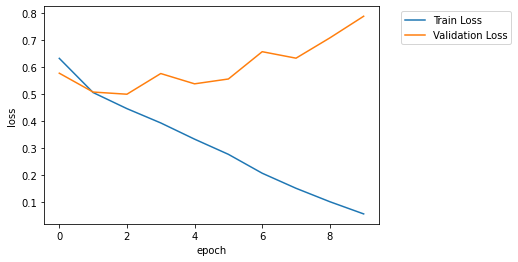

In [ ]:
#plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('lossclassifier.png')
plt.show()

Prediction

In [27]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i']


In [84]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)
x = "If you're going to watch this movie, avoid any spoilers, even spoiler free reviews. Which is why I'm not going to say anything about the movie. Not even my opinion. All I'm going to say is: The crowd applauded 3 times during the movie, and stood up to clap their hands after. This I have never witnessed in a Dutch cinema. Dutch crowds aren't usually passionate about this. I checked the row where I was sitting, and people were crying. After the movie, I was seeing people with smudged mascara. That's all I have to say about the movie."
list_of_strings = [tok.text for tok in tokenizer(x)]
print(list_of_strings)

['If', "you're", 'going', 'to', 'watch', 'this', 'movie,', 'avoid', 'any', 'spoilers,', 'even', 'spoiler', 'free', 'reviews.', 'Which', 'is', 'why', "I'm", 'not', 'going', 'to', 'say', 'anything', 'about', 'the', 'movie.', 'Not', 'even', 'my', 'opinion.', 'All', "I'm", 'going', 'to', 'say', 'is:', 'The', 'crowd', 'applauded', '3', 'times', 'during', 'the', 'movie,', 'and', 'stood', 'up', 'to', 'clap', 'their', 'hands', 'after.', 'This', 'I', 'have', 'never', 'witnessed', 'in', 'a', 'Dutch', 'cinema.', 'Dutch', 'crowds', "aren't", 'usually', 'passionate', 'about', 'this.', 'I', 'checked', 'the', 'row', 'where', 'I', 'was', 'sitting,', 'and', 'people', 'were', 'crying.', 'After', 'the', 'movie,', 'I', 'was', 'seeing', 'people', 'with', 'smudged', 'mascara.', "That's", 'all', 'I', 'have', 'to', 'say', 'about', 'the', 'movie.']


In [67]:
context = [TEXT.vocab.stoi[c] for c in list_of_strings]
context = np.asarray(context)
context = torch.from_numpy(context)

torch.Size([99])

In [78]:
with torch.no_grad():
  model.eval()
  x = context.view(1, -1)
  input = x.to(device)
  print(input.shape)
  out = model(input)

print (out)
label = out.argmax(dim=1)
print (label)

label += 1
print (label)
print(LABEL.vocab.itos[label])


torch.Size([1, 99])
tensor([[-0.4641, -0.9907]], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
pos
